Step 1: PREPROCESSING

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score

# Function to calculate Multi-Level OFI

# Function to preprocess a single file
def preprocess_lob_data_fixed(file_path, levels=5):
    """
    Preprocess Limit Order Book (LOB) data with improved error handling.
    """
    # Load data
    lob_data = pd.read_csv(file_path)
    lob_data.columns = lob_data.columns.str.strip().str.lower()

    # Ensure timestamp column exists
    if 'ts_event' not in lob_data.columns:
        raise ValueError("Missing 'ts_event' column in data.")

    # Create timestamp and sort
    lob_data['timestamp'] = pd.to_datetime(lob_data['ts_event'])
    lob_data.sort_values(by='timestamp', inplace=True)

    # Fill missing values
    lob_data.fillna(method='ffill', inplace=True)
    lob_data.fillna(method='bfill', inplace=True)

    # Select relevant columns
    level_columns = ['timestamp']
    for i in range(1, levels + 1):
        level_columns.extend([f'bid_px_0{i}', f'bid_sz_0{i}', f'ask_px_0{i}', f'ask_sz_0{i}'])

    valid_columns = [col for col in level_columns if col in lob_data.columns]
    filtered_data = lob_data[valid_columns]

    # Ensure data is not empty
    if filtered_data.empty:
        print("Warning: Filtered dataset is empty. Returning original dataset.")
        return lob_data

    return filtered_data

# Define file paths for the uploaded datasets
file_paths = {
    "AAPL": "/content/AAPL.csv",
    "AMGN": "/content/AMGN.csv",
    "JPM": "/content/JPM.csv",
    "TSLA": "/content/TSLA.csv",
    "XOM": "/content/XOM.csv"
}

# Preprocess all files and save the cleaned data
processed_data = {}
for stock, path in file_paths.items():
    processed_data[stock] = preprocess_lob_data_fixed(path)
    # Save each processed file
    processed_data[stock].to_csv(f"/content/Processed/Processed_{stock}.csv", index=False)

print("Processing complete. Processed files saved.")

Processing complete. Processed files saved.


<ipython-input-4-985a3bf5f62e>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lob_data.fillna(method='ffill', inplace=True)
<ipython-input-4-985a3bf5f62e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lob_data.fillna(method='bfill', inplace=True)
<ipython-input-4-985a3bf5f62e>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lob_data.fillna(method='ffill', inplace=True)
<ipython-input-4-985a3bf5f62e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lob_data.fillna(method='bfill', inplace=True)
<ipython-input-4-985a3bf5f62e>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future ve

Step 2: Compute OFI Metrics

In [13]:
def calculate_ofi(data):
    """
    Calculate Order Flow Imbalance (OFI) for bid and ask sides at 5 levels.
    Args:
        data (pd.DataFrame): Processed LOB data with bid and ask prices/sizes.
    Returns:
        pd.DataFrame: Data with OFI columns added for all 5 levels.
    """
    for level in range(1, 6):  # For levels 1 to 5
        bid_price_col = f'bid_px_0{level}'
        bid_size_col = f'bid_sz_0{level}'
        ask_price_col = f'ask_px_0{level}'
        ask_size_col = f'ask_sz_0{level}'

        # Calculate bid-side OFI
        data[f'ofi_bid_{level}'] = np.where(
            data[bid_price_col] > data[bid_price_col].shift(1),
            data[bid_size_col],
            np.where(
                data[bid_price_col] == data[bid_price_col].shift(1),
                data[bid_size_col] - data[bid_size_col].shift(1),
                -data[bid_size_col]
            )
        )

        # Calculate ask-side OFI
        data[f'ofi_ask_{level}'] = np.where(
            data[ask_price_col] > data[ask_price_col].shift(1),
            -data[ask_size_col],
            np.where(
                data[ask_price_col] == data[ask_price_col].shift(1),
                data[ask_size_col] - data[ask_size_col].shift(1),
                data[ask_size_col]
            )
        )

    return data
# Function to integrate Multi-Level OFI using PCA
def integrate_ofi_with_pca(data):
    """
    Integrate multi-level OFI using PCA.
    Args:
        data (pd.DataFrame): LOB data with OFI columns for each level.
    Returns:
        pd.DataFrame: Data with integrated OFI column added.
    """
    ofi_columns = [f'ofi_bid_{i}' for i in range(1, 6)] + [f'ofi_ask_{i}' for i in range(1, 6)]

    # Ensure the columns exist and are valid
    ofi_columns = [col for col in ofi_columns if col in data.columns]
    if not ofi_columns:
        raise ValueError("No valid OFI columns found for PCA integration.")

    # Fill NaN values with 0 for PCA
    ofi_data = data[ofi_columns].fillna(0)

    # Check if there are enough rows for PCA
    if ofi_data.shape[0] < 1:
        raise ValueError("No data available for PCA integration. Check input dataset.")

    # Apply PCA
    pca = PCA(n_components=1)
    integrated_ofi = pca.fit_transform(ofi_data)
    data['ofi_integrated'] = integrated_ofi
    return data

# Example Usage: Calculate OFI for all stocks
processed_data_with_ofi = {}
for stock, df in processed_data.items():
    df = calculate_ofi(df)
    df = integrate_ofi_with_pca(df)
    processed_data_with_ofi[stock] = df

Step 3: Analyze Cross-Impact

In [10]:
# Step 1: Add Returns Calculation to Preprocessing
def calculate_returns(data):
    mid_price = (data['bid_px_01'] + data['ask_px_01']) / 2
    returns = mid_price.pct_change().fillna(0)
    return returns

for stock, df in processed_data_with_ofi.items():
    df['returns'] = calculate_returns(df)

# Step 2: Analyze Contemporaneous Cross-Impact
def analyze_cross_impact(processed_data):
    stock_names = list(processed_data.keys())
    integrated_ofis = {stock: df['ofi_integrated'] for stock, df in processed_data.items()}
    returns = {stock: df['returns'] for stock, df in processed_data.items()}

    # Create a matrix of OFIs and returns
    X = np.column_stack([integrated_ofis[stock] for stock in stock_names])
    y = np.column_stack([returns[stock] for stock in stock_names])

    # Linear regression for cross-impact
    model = LinearRegression()
    model.fit(X, y)
    cross_impact_coefficients = pd.DataFrame(model.coef_, columns=stock_names, index=stock_names)
    return cross_impact_coefficients

cross_impact_coefficients = analyze_cross_impact(processed_data_with_ofi)

# Step 3: Evaluate Predictive Power
def predictive_power(processed_data, lag=1):
    results = {}
    for stock, df in processed_data.items():
        X = df['ofi_integrated'].shift(lag).fillna(0).values.reshape(-1, 1)
        y = df['returns'].values

        model = LassoCV(cv=5)
        model.fit(X, y)
        predictions = model.predict(X)
        results[stock] = r2_score(y, predictions)
    return results

predictive_r2 = predictive_power(processed_data_with_ofi)

# Step 4: Print Results
print("Cross-Impact Coefficients:")
print(cross_impact_coefficients)

print("Predictive R-Squared Values:")
print(predictive_r2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

Cross-Impact Coefficients:
          AAPL      AMGN       JPM          TSLA       XOM
AAPL  0.000052  0.000524  0.000047  1.980426e-07  0.000071
AMGN  0.000000  0.000000  0.000000  0.000000e+00  0.000000
JPM   0.000032 -0.000685 -0.000077 -1.416419e-06 -0.000210
TSLA -0.000004 -0.000148  0.000008 -1.556165e-07  0.000017
XOM  -0.000013  0.000070 -0.000067 -4.450272e-07 -0.000548
Predictive R-Squared Values:
{'AAPL': 0.0, 'AMGN': 1.0, 'JPM': 0.0, 'TSLA': 0.0, 'XOM': 0.37167073061272393}


Step 4: Quantify Results

In [11]:
# Print R-squared values for predictive power
print("R-squared values for predictive models:")
print(predictive_r2)

# Compare cross-impact coefficients
print("Cross-impact coefficients:")
print(cross_impact_coefficients)

R-squared values for predictive models:
{'AAPL': 0.0, 'AMGN': 1.0, 'JPM': 0.0, 'TSLA': 0.0, 'XOM': 0.37167073061272393}
Cross-impact coefficients:
          AAPL      AMGN       JPM          TSLA       XOM
AAPL  0.000052  0.000524  0.000047  1.980426e-07  0.000071
AMGN  0.000000  0.000000  0.000000  0.000000e+00  0.000000
JPM   0.000032 -0.000685 -0.000077 -1.416419e-06 -0.000210
TSLA -0.000004 -0.000148  0.000008 -1.556165e-07  0.000017
XOM  -0.000013  0.000070 -0.000067 -4.450272e-07 -0.000548


Step 5: Visualize Results

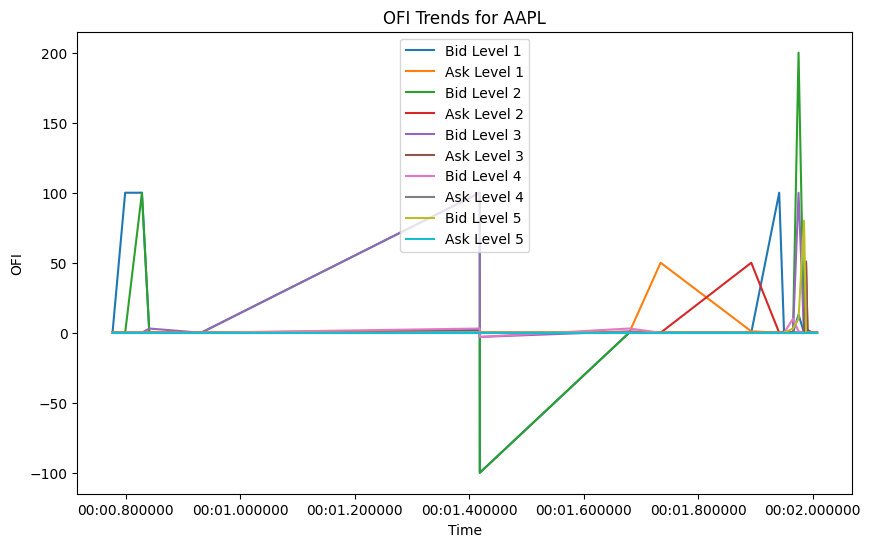

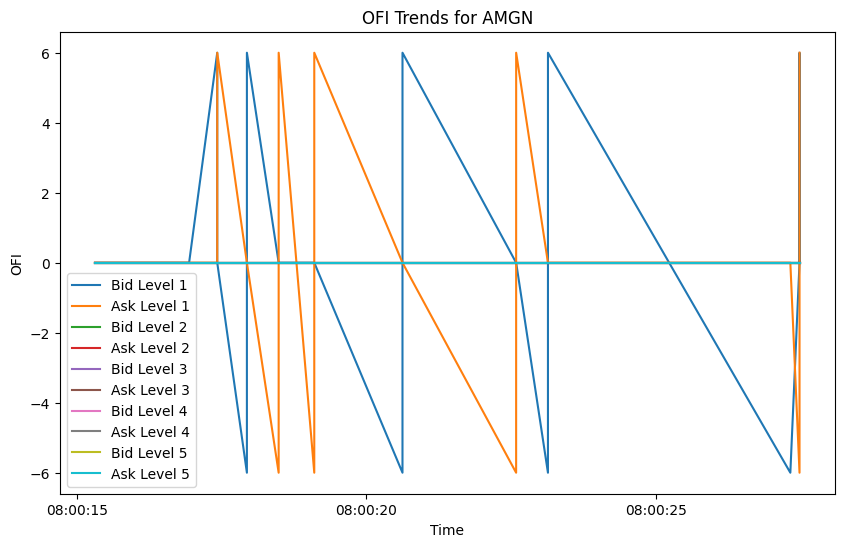

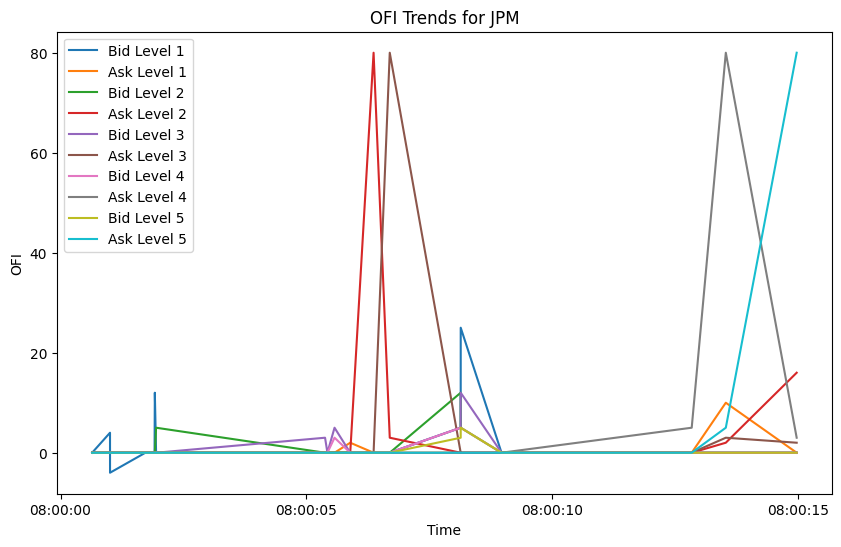

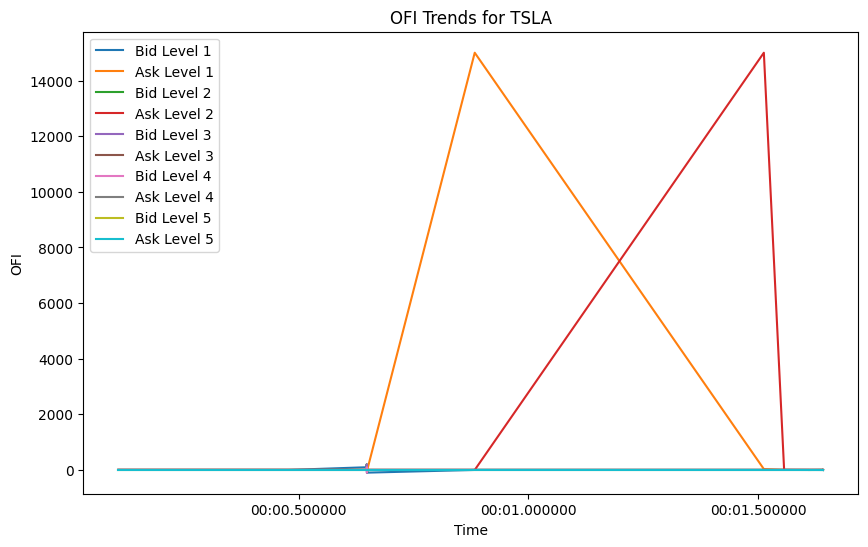

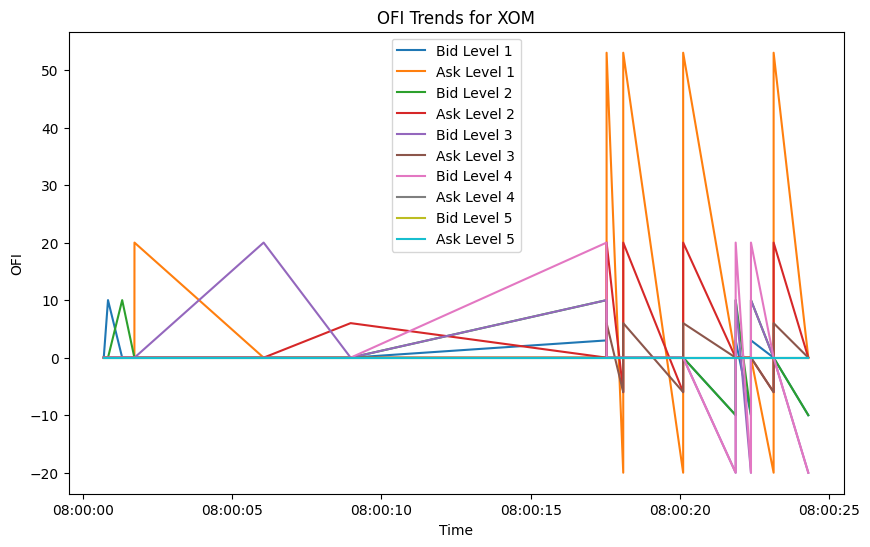

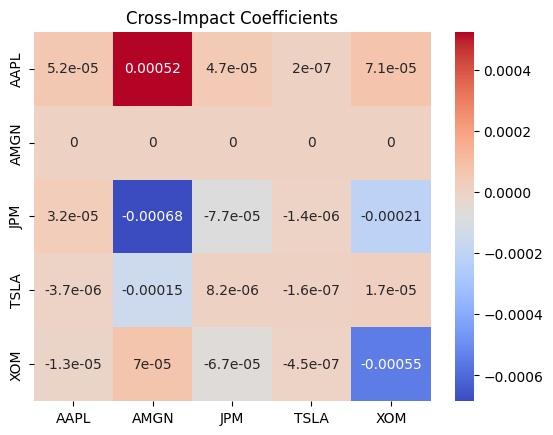

In [16]:
# Plot OFI trends for a stock
def plot_ofi_trends(stock, df):
    plt.figure(figsize=(10, 6))
    for level in range(1, 6):
        plt.plot(df['timestamp'], df[f'ofi_bid_{level}'], label=f'Bid Level {level}')
        plt.plot(df['timestamp'], df[f'ofi_ask_{level}'], label=f'Ask Level {level}')
    plt.title(f"OFI Trends for {stock}")
    plt.xlabel("Time")
    plt.ylabel("OFI")
    plt.legend()
    plt.show()

plot_ofi_trends("AAPL", processed_data_with_ofi["AAPL"])
plot_ofi_trends("AMGN", processed_data_with_ofi["AMGN"])
plot_ofi_trends("JPM", processed_data_with_ofi["JPM"])
plot_ofi_trends("TSLA", processed_data_with_ofi["TSLA"])
plot_ofi_trends("XOM", processed_data_with_ofi["XOM"])

# Heatmap for cross-impact relationships
sns.heatmap(cross_impact_coefficients, annot=True, cmap='coolwarm')
plt.title("Cross-Impact Coefficients")
plt.show()